In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydot
import scipy.sparse as sp
import warnings
import itertools
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score
from IPython.display import SVG
from keras import backend as K
from keras.utils.vis_utils import model_to_dot
from keras.models import Model
from keras.layers import Input, Embedding, Dot, Flatten, Lambda
from keras.optimizers import Adagrad, Adam, SGD, RMSprop

Using TensorFlow backend.


## Load data and split train and test set

In [2]:
# Split Movielens 100K data into train and test (80-20)
np.seed = 1
dataset = pd.read_csv("../data/u.data",sep='\t',names="user_id,item_id,rating,timestamp".split(","))
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values
train, test = train_test_split(dataset, test_size=0.2)

## Sparse matrices, triplets, loss function and AUC

In [3]:
# Parse movielens dataset lines
def _parse(data):
    for index, row in data.iterrows():

        uid, iid, rating, timestamp = [int(value) for _, value in row.iteritems()]
        
        yield uid, iid, rating, timestamp

In [4]:
# Used to return train and test interactions
def get_movielens_data(data):
    rows = max(dataset.user_id) + 1
    cols = max(dataset.item_id) + 1

    mat = sp.lil_matrix((rows, cols), dtype=np.int32)

    for uid, iid, rating, timestamp in data:
        # Let's assume only really good ratings are positives
        if rating >= 4.0:
            mat[uid, iid] = 1.0

    return mat.tocoo()

In [5]:
# Returns triplets (user, known positive item, randomly sampled negative item)
def get_triplets(mat):
    return mat.row, mat.col, np.random.randint(mat.shape[1], size=len(mat.row))

In [6]:
def identity_loss(y_true, y_pred):
    return K.mean(y_pred - 0 * y_true)

In [7]:
def bpr_triplet_loss(X):
    positive_item_latent, negative_item_latent, user_latent = X

    # BPR loss
    loss = 1.0 - K.sigmoid(
        K.sum(user_latent * positive_item_latent, axis=-1, keepdims=True) -
        K.sum(user_latent * negative_item_latent, axis=-1, keepdims=True))

    return loss

In [8]:
# Predict function
def predict(model, uid, pids):
    user_vector = model.get_layer('user_embedding').get_weights()[0][uid]
    item_matrix = model.get_layer('item_embedding').get_weights()[0][pids]

    scores = (np.dot(user_vector,
                     item_matrix.T))

    return scores

In [9]:
# Measure AUC for model and ground truth on all items
def full_auc(model, ground_truth):
    ground_truth = ground_truth.tocsr()

    no_users, no_items = ground_truth.shape

    pid_array = np.arange(no_items, dtype=np.int32)

    scores = []

    for user_id, row in enumerate(ground_truth):

        predictions = predict(model, user_id, pid_array)

        true_pids = row.indices[row.data == 1]

        grnd = np.zeros(no_items, dtype=np.int32)
        grnd[true_pids] = 1

        if len(true_pids):
            scores.append(roc_auc_score(grnd, predictions))

    return sum(scores) / len(scores)

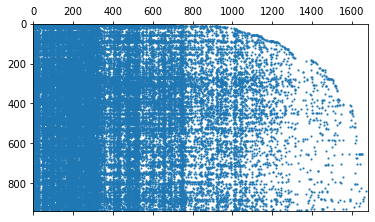

In [10]:
plt.spy(get_movielens_data(_parse(train)), markersize=1)

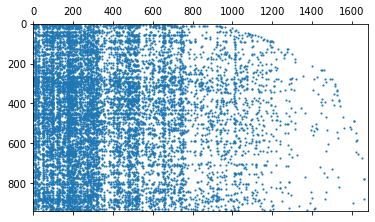

In [11]:
plt.spy(get_movielens_data(_parse(test)), markersize=1)

## Building the model

In [12]:
train_inter = get_movielens_data(_parse(train))
test_inter = get_movielens_data(_parse(test))

In [13]:
latent_dim = 100
# Set item input and embedding
positive_item_input = Input((1, ), name='positive_item_input')
negative_item_input = Input((1, ), name='negative_item_input')

# Shared embedding layer for positive and negative items
item_embedding_layer = Embedding(train_inter.shape[1], latent_dim, name='item_embedding', input_length=1)

positive_item_embedding = Flatten()(item_embedding_layer(positive_item_input))
negative_item_embedding = Flatten()(item_embedding_layer(negative_item_input))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [14]:
# Set user input and embedding
user_input = Input((1, ), name='user_input')

user_embedding = Flatten()(Embedding(train_inter.shape[0], latent_dim, name='user_embedding', input_length=1)(user_input))

In [15]:
triplet_loss = Lambda(bpr_triplet_loss, output_shape=(1, ))([positive_item_embedding, negative_item_embedding, user_embedding])

In [16]:
model = Model(inputs=[positive_item_input, negative_item_input, user_input], outputs=triplet_loss)
model.compile(loss=identity_loss, optimizer=Adam())

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
positive_item_input (InputLayer (None, 1)            0                                            
__________________________________________________________________________________________________
negative_item_input (InputLayer (None, 1)            0                                            
__________________________________________________________________________________________________
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 100)       168200      positive_item_input[0][0]        
                                                                 negative_item_input[0][0]  

In [17]:
num_epochs = 10

for epoch in range(num_epochs):
    print('Epoch %s' % epoch)

    # Sample triplets from the training data
    uid, pid, nid = get_triplets(train_inter)

    X = {
        'user_input': uid,
        'positive_item_input': pid,
        'negative_item_input': nid
    }

    model.fit(X,
              np.ones(len(uid)),
              batch_size=64,
              nb_epoch=1,
              verbose=0,
              shuffle=True)

    print('AUC %s' % full_auc(model, test_inter))

Epoch 0

AUC 0.8415621776447423
Epoch 1
AUC 0.8655249256582148
Epoch 2
AUC 0.8745418727847076
Epoch 3
AUC 0.8832957361152078
Epoch 4
AUC 0.8906786440646983
Epoch 5
AUC 0.8959154410027459
Epoch 6
AUC 0.9004432874668218
Epoch 7
AUC 0.904386270650725
Epoch 8
AUC 0.9073247079455304
Epoch 9
AUC 0.9099989644348411
